### Linear Regression
**Author:** René Kopeinig<br>
**Description:** Time Series Prediction using Proba-V NDVI (Normalized Difference Vegetation Index), Landsat 8 NDVI and CHIRPS precipitation Time-Series.

In [1]:
%matplotlib inline

In [3]:
# Import Dependencies
import ee, datetime
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from IPython.display import Image
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
ee.Initialize()

In [61]:
def normalize(x):
    normalized = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    return normalized

### Load Proba-V, Landsat 8 TOA and CHIRPS  image collection and point geometry
Selected Location of point is from the Proba-V Footprint X18Y02 in Luxembourg, Europe. 

In [4]:
# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2018, 4, 15)

# Create image collection
l8 = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filterDate(startTime, endTime)
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(startTime, endTime)
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
# Create point in Luxembourg (Proba-V Footprint: X18Y02)
point = {'type':'Point', 'coordinates':[-99.545934,20.572173]};

### Retrieve information, reshape & calculate NDVI and extract precipitation information
Retrieving information from point geometry with a buffer of 500m over image collection. Reshaping data and calculating NDVI from **RED** and **NIR** band.

In [5]:
info_l8 = l8.getRegion(point,500).getInfo()
info_chirps = precipitation.getRegion(point, 500).getInfo()
info_probav = probav.getRegion(point, 500).getInfo()

In [6]:
# Reshape Landsat 8
header = info_l8[0]
data = array(info_l8[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['B5',u'B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# Reshape NDVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi*-1, index=time, columns=['ndvi'])
l8_time_series = df.dropna()

# Resampling
monthly_landsat = l8_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


In [7]:
# Reshape Chirps precipitation data 
header = info_chirps[0]
data = array(info_chirps[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['precipitation']
iBands = [header.index(b) for b in band_list]
chirps = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=chirps, index=time, columns=['precipitation'])
chirps_time_series = df.dropna()

# Resampling
monthly_chirps = chirps_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


In [8]:
# Reshape Proba-V image collection 
header = info_probav[0]
data = array(info_probav[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['NDVI']
iBands = [header.index(b) for b in band_list]
ndvi = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=ndvi, index=time, columns=['ndvi'])
probav_time_series = df.dropna()

# Resampling
monthly_probav = probav_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


### Plot Landsat 8 NDVI Time Series

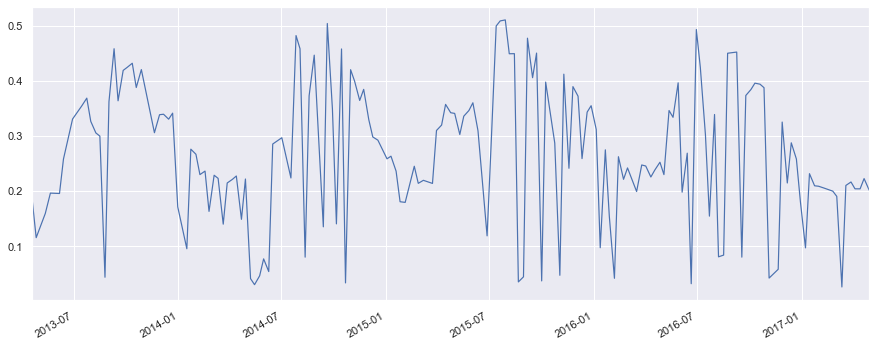

In [14]:
sns.set(rc={'figure.figsize':(15, 6)})
l8_time_series['ndvi'].plot(linewidth=1.2)

### Plot Proba-V NDVI Time Series

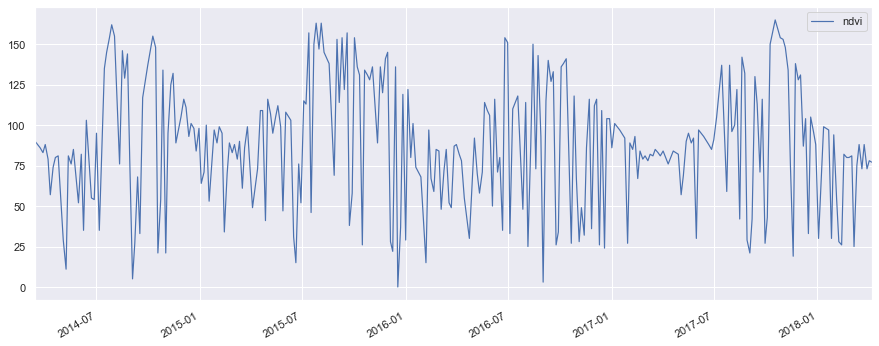

In [15]:
probav_time_series.plot(linewidth=1.2)

### Plot CHIRPS Precipitation Time Series

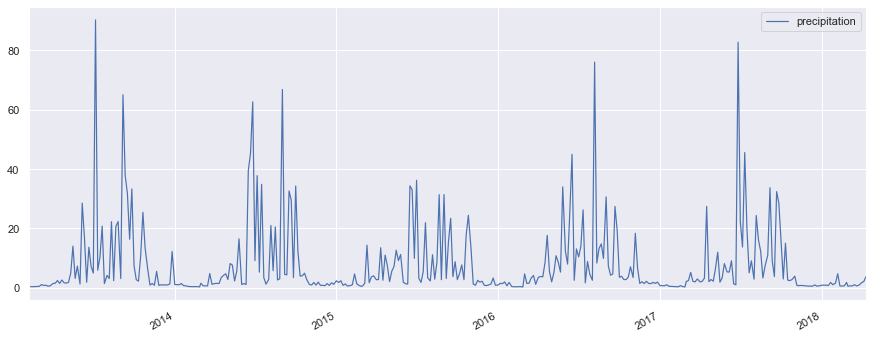

In [16]:
chirps_time_series.plot(linewidth=1.2)

### Reshape Data and plot
Let's bring all Time Series on an equal base, reshape and join them in one data frame. Creating Pair Plots in order to take a closer look into the data.

In [17]:
monthly_chirps = monthly_chirps['2014-04':'2017-04']
monthly_landsat = monthly_landsat['2014-04':'2017-04']
monthly_probav = monthly_probav['2014-04':'2017-04']

In [47]:
monthly = pd.DataFrame({'landsat': monthly_landsat['ndvi'],
                        'chirps': monthly_chirps['precipitation'],
                        'probav':monthly_probav['ndvi']},index = monthly_chirps.index)

/Users/rkopei/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


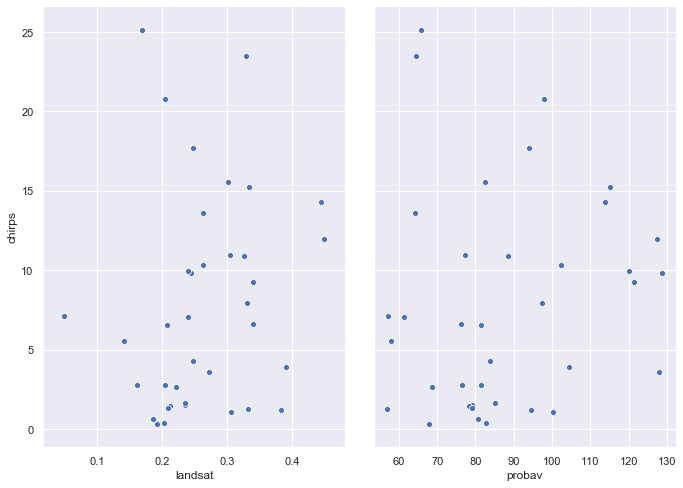

In [48]:
sns.pairplot(monthly, x_vars=['landsat', 'probav'], y_vars=['chirps'], size=7, aspect=0.7)

### Linear Regression comparing Sklearn and Statsmodels

In [49]:
# Statsmodels
lm_1 = smf.ols(formula='chirps ~ landsat', data=monthly).fit()

# Print the coefficients
print(lm_1.params)

Intercept     4.081701
landsat      14.312617
dtype: float64


In [50]:
# Sklearn

cols = ['landsat']
X = monthly[cols]
y = monthly.chirps

# instantiate and fit
lm_2 = LinearRegression()
lm_2.fit(X, y)

# print the coefficients
print('Intercept: ', lm_2.intercept_)
print('landsat: ', lm_2.coef_[0])

Intercept:  4.081700556631769
landsat:  14.312617180230179


### Plot Least Square Line

/Users/rkopei/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


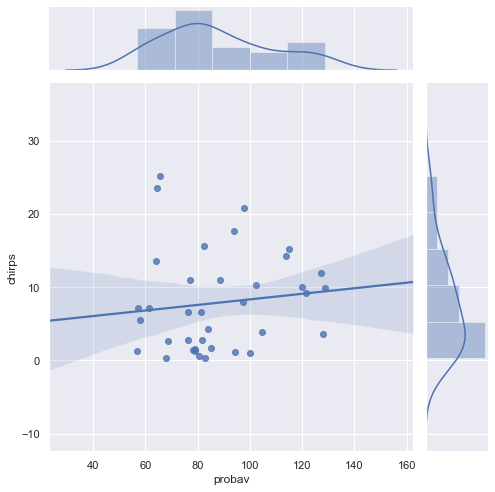

In [51]:
sns.jointplot("probav", "chirps", data=monthly, size=7, kind='reg')

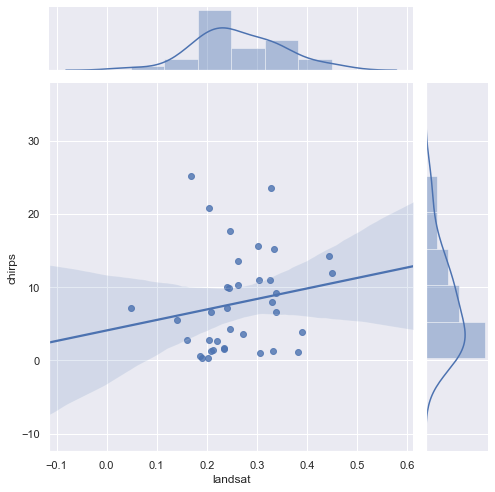

In [52]:
sns.jointplot("landsat", "chirps", data=monthly, size=7, kind='reg')

### Linear Regression Prediction

In [71]:
lm = smf.ols(formula='chirps ~ landsat*probav', data=monthly).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 chirps   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.3829
Date:                Wed, 09 Oct 2019   Prob (F-statistic):              0.766
Time:                        16:37:16   Log-Likelihood:                -122.06
No. Observations:                  37   AIC:                             252.1
Df Residuals:                      33   BIC:                             258.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0991     14.876      0.410      0.684     -24.166      36.364
landsat            2.9669     54.153      0.055      0.957    -107.208     113.142
probav            -0.0199      0.179     -0.111      0.912      -0.384       0.344
landsat:probav     0.1133      0.597      0.190      0.851      -1.101       1.328
==============================================================================
Omnibus:                        8.845   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.822
Skew:                           1.079   Prob(JB):                       0.0200
Kurtosis:                       3.643   Cond. No.                     4.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
model_linear_pred = lm.predict()
monthly['pred']=model_linear_pred

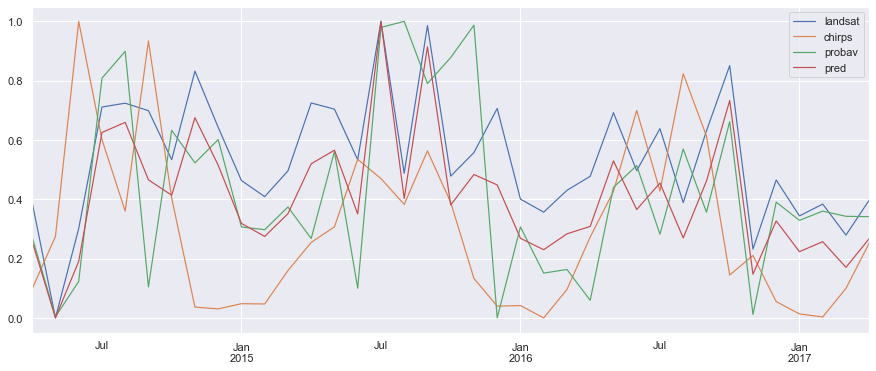

In [73]:
normalize(monthly).plot(linewidth=1.2)